<a href="https://colab.research.google.com/github/TomPhanAnh/Kaggle-Solution/blob/main/Ethereum_synchronicity%2C_upside_volatility_and_Bitcoin_crash_risk_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression
import math

# Import statsmodels to output data
import statsmodels.api as sm
import  statsmodels.formula.api as smf 

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# Import pandas_datareader to collect data, datetime as specify event period and time-series columns as daily 
import pandas_datareader.data as web
import datetime


# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# yahoo finance is used to fetch data
! pip install yfinance
import yfinance as yf

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install bitfinex-tencars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Control variables including:**
 - Daily return of gold price (gold), 
 - Stand & Poor Index (spx), 
 - Dollar index (usdx), 
 - Volatility index (vix), 
 - WTI crude oil (wti), 
 - 30-year treasury bond (T − bond), and 
 - Investor sentiment index data issued by Federal Reserve Bank of San
Francisco (sentiment). 

In [4]:
import pandas as pd
import pandas_datareader.data as web
import datetime
from datetime import timedelta

start_date = datetime.date(2016,6,1)
end_date   = datetime.date(2022,5,22)
delta =  datetime.timedelta(days = 7)

# Stand & Poor Index (spx)
SP_500_index = web.DataReader(['sp500'],'fred',start_date,end_date)

# Investor sentiment index data issued by Federal Reserve Bank of San Francisco (sentiment).
sentiment = pd.read_csv("sentiment.csv",parse_dates = ["Date"])
sentiment = sentiment[sentiment['Date'].apply(lambda x: x >= start_date and x <= end_date)]
sentiment.rename(columns = {"News Sentiment":"News_Sentiment"}, inplace = True)
sentiment["Sentiment"] = sentiment["News_Sentiment"]/sentiment["News_Sentiment"].shift(1) - 1

# daily return of gold price (gold)
gold = yf.download("GLD",'2008-01-01','2022-05-22',auto_adjust = True)[['Close']]
gold["Return_gold"] = gold["Close"]/gold["Close"].shift(1) - 1
gold.rename(columns = {"Close":"Gold"}, inplace = True)

# 30-year treasury bond (T − bond)
B_T = yf.download("^TYX",        start_date, end_date,auto_adjust = True)[['Close']].reset_index()
B_T.rename(columns = {"Close":"T_Bill"}, inplace = True)

# dollar index (usdx)
D_index = yf.download("DX-Y.NYB",start_date, end_date,auto_adjust = True)[['Close']].reset_index()
D_index.rename(columns = {"Close":"Dollar_Index"}, inplace = True)

# volatility index (vix),
vix = yf.download("^VIX" ,       start_date, end_date,auto_adjust = True)[['Close']].reset_index()
vix.rename(columns = {"Close":"VIX"}, inplace = True)

# wti crude oil (wti)
wti = yf.download("WTI",         start_date, end_date,auto_adjust = True)[['Close']].reset_index()
wti.rename(columns = {"Close":"WTI_Oil_price"}, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Import **Bitcoin (BTC) and Ethereum (ETH-USD) dataset** from yahoo finance at ***30 minutes level/interval***

In [5]:
import bitfinex
import datetime
import time
import pandas as pd

start_date = datetime.datetime(2016,5,31,0,0)
start_date = time.mktime(start_date.timetuple()) * 1000
end_date   = datetime.datetime(2022,5,21,0,0)
end_date = time.mktime(end_date.timetuple()) * 1000

# Create api instance of the v2 API
api_v2 = bitfinex.bitfinex_v2.api_v2()

# Define query parameters
pair = 'BTCUSD' # Currency pair of interest
interval = '30m'#,'4h','1h','15m','1m'
names = ['Date', 'Open', 'Close', 'High', 'Low', 'Volume'] # Columns name

# Create a blank dataframe of Bitcoin
BTC = pd.DataFrame(columns = names)
BTC["Date"] = pd.to_datetime(BTC["Date"]) # Specify the Date columns as Date type

for i in range(10000):
  # Download OHCL data from API
  
  while end_date >= start_date:
    try:
      result = api_v2.candles(symbol = pair, interval = interval, limit = 10000, start = start_date, end= end_date)
  # Convert list of data to pandas dataframe
      df = pd.DataFrame(result, columns = names)
      df["Date"] = pd.to_datetime(df["Date"], unit = "ms")
  
  # Concatenate the dataframe to create bitcoin dataset
      BTC = pd.concat([df,BTC])
      x = df.iloc[-1,0]
  
  # Recreate/reset the end date to begin new loop
      end_date = datetime.datetime(x.year,x.month,x.day,x.hour,x.minute)
      end_date = time.mktime(end_date.timetuple()) * 1000
  # In case the result is unaccepted, we use try/except to remove the bug and continue to concatenate the date at the stopping date
    except:
      break 
      end_datex = datetime.datetime(x.year,x.month,x.day,x.hour,x.minute)
      end_datex = time.mktime(end_datex.timetuple()) * 1000
      result_x = api_v2.candles(symbol = pair, interval = interval, limit = 10000, start = start_date, end= end_datex)
      df_x = pd.DataFrame(result_x, columns = names)
      df_x["Date"] = pd.to_datetime(df_x["Date"], unit = "ms")  
      BTC = pd.concat([df_x,BTC])
#----------------------------------------------------------------------------------------
  y = BTC.iloc[-1,0] 
  end_date = datetime.datetime(y.year,y.month,y.day,y.hour,y.minute)
  end_date = time.mktime(end_date.timetuple()) * 1000

# Sort dataset by Date columns
BTC = BTC.sort_values(by = "Date").set_index("Date").reset_index()
# Drop Duplicates
BTC.drop_duplicates(subset = "Date", inplace = True)
BTC_30m = BTC.copy()

No keys, only access to public API functions


In [6]:
BTC.head(5)

,Date,Open,Close,High,Low,Volume
0,2016-05-31 00:00:00,533.14,536.43,536.43,533.14,297.494381
51,2016-05-31 00:30:00,536.43,537.36,538.00,534.68,458.270734
102,2016-05-31 01:00:00,537.36,537.54,539.41,535.54,523.187278
153,2016-05-31 01:30:00,537.59,537.58,538.16,536.04,345.739438
204,2016-05-31 02:00:00,537.59,539.40,539.41,536.55,455.711805


###**Ethereum Dataset from 1/6/2016 - 21/5/2022 at 30 minutes level/interval**

Rerun if error

In [8]:
import bitfinex
import datetime
import time
import pandas as pd

start_date = datetime.datetime(2016,6,1,0,0)
start_date = time.mktime(start_date.timetuple()) * 1000
end_date   = datetime.datetime(2022,5,21,0,0)
end_date = time.mktime(end_date.timetuple()) * 1000

# Create api instance of the v2 API
api_v2 = bitfinex.bitfinex_v2.api_v2()

# Define query parameters
pair = 'ETHUSD' # Currency pair of interest
interval = '30m'#,'4h','1h','15m','1m'
names = ['Date', 'Open', 'Close', 'High', 'Low', 'Volume'] # Columns name

# Create a blank dataframe of Bitcoin
ETH = pd.DataFrame(columns = names)
ETH["Date"] = pd.to_datetime(ETH["Date"]) # Specify the Date columns as Date type

for i in range(10000):
  # Download OHCL data from API
  
  while end_date >= start_date:
    try:
      result = api_v2.candles(symbol = pair, interval = interval, limit = 10000, start = start_date, end= end_date)
  # Convert list of data to pandas dataframe
      df = pd.DataFrame(result, columns = names)
      df["Date"] = pd.to_datetime(df["Date"], unit = "ms")
  
  # Concatenate the dataframe to create bitcoin dataset
      ETH = pd.concat([df,ETH])
      x = df.iloc[-1,0]
  
  # Recreate/reset the end date to begin new loop
      end_date = datetime.datetime(x.year,x.month,x.day,x.hour,x.minute)
      end_date = time.mktime(end_date.timetuple()) * 1000
  # In case the result is unaccepted, we use try/except to remove the bug and continue to concatenate the date at the stopping date
    except:
      break 
      end_datex = datetime.datetime(x.year,x.month,x.day,x.hour,x.minute)
      end_datex = time.mktime(end_datex.timetuple()) * 1000
      result_x = api_v2.candles(symbol = pair, interval = interval, limit = 10000, start = start_date, end= end_datex)
      df_x = pd.DataFrame(result_x, columns = names)
      df_x["Date"] = pd.to_datetime(df_x["Date"], unit = "ms")  
      ETH = pd.concat([df_x,ETH])

#----------------------------------------------------------------------------------------
  y = ETH.iloc[-1,0] 
  end_date = datetime.datetime(y.year,y.month,y.day,y.hour,y.minute)
  end_date = time.mktime(end_date.timetuple()) * 1000

# Sort dataset by Date columns
ETH = ETH.sort_values(by = "Date").set_index("Date").reset_index()

# Drop Duplicates
ETH.drop_duplicates(subset = "Date", inplace = True)
ETH_30m = ETH.copy()

# Remember to copy the new dataframe to calculate the R2 - SYNC
ETH['Return'] = ETH['Close']/ETH['Close'].shift(-1) - 1
print("Data Ethereum updated successfully")

No keys, only access to public API functions
Data Ethereum updated successfully


In [9]:
ETH.head(5)

,Date,Open,Close,High,Low,Volume,Return
0,2016-06-01 00:00:00,14.131,14.050,14.280,14.050,4276.577559,-0.004111
44,2016-06-01 00:30:00,14.050,14.108,14.126,14.020,1277.969660,0.006995
88,2016-06-01 01:00:00,14.108,14.010,14.120,14.010,1289.121018,0.002146
132,2016-06-01 01:30:00,14.011,13.980,14.011,13.927,1897.780844,-0.009284
176,2016-06-01 02:00:00,13.982,14.111,14.116,13.982,989.202090,-0.005567


### **Bitcoin- Ethereum Dataset from 1/6/2016 - 21/5/2022 at 1-day minutes level/interval**

In [10]:
BTC_1d = yf.download("BTC-USD",start = "2016-05-31", end = "2022-05-21", interval = '1d', auto_adjust = True)
BTC_1d["Return"] = BTC_1d["Close"]/BTC_1d["Close"].shift(1) - 1

# ETH_1d data
ETH_1d = yf.download("ETH-USD",start = "2016-05-31", end = "2022-05-21", interval = '1d', auto_adjust = True)

# BTC_data is Dataset of bitcoin with interval of 1d => Calculate DUVOL & NCSKEW
BTC_1d.reset_index(inplace = True)
BTC_1d["Year"]  = BTC_1d["Date"].apply(lambda x: x.year)
BTC_1d["Month"] = BTC_1d["Date"].apply(lambda x: x.month)
BTC_1d["Day"]   = BTC_1d["Date"].apply(lambda x: x.day)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
BTC_1d.head(5)

,Date,Open,High,Low,Close,Volume,Return,Year,Month,Day
0,2016-05-31,534.190979,546.617981,520.661987,531.385986,138450000,NaN,2016,5,31
1,2016-06-01,531.106995,543.080017,525.635986,536.919983,86061800,0.010414,2016,6,1
2,2016-06-02,536.515015,540.351990,533.078003,537.971985,60378200,0.001959,2016,6,2
3,2016-06-03,537.682007,574.638000,536.919983,569.193970,122020000,0.058036,2016,6,3
4,2016-06-04,569.705017,590.132019,564.237976,572.726990,94925296,0.006207,2016,6,4


In [12]:
# Update BTC_30m dataset with Year/Month/Day
BTC["Return"] = BTC["Close"]/BTC["Close"].shift(-1) - 1 
BTC["Year"]  = BTC["Date"].apply(lambda x: x.year)
BTC["Month"] = BTC["Date"].apply(lambda x: x.month)
BTC["Day"]   = BTC["Date"].apply(lambda x: x.day)
BTC["crash_time"] = BTC['Return'].apply(lambda x: 1 if x >= 0 else 0)

BTC["Return"] = BTC["Return"].apply(lambda x: math.pow(x,2))


# BTC_DUVOL_0 and BTC_DUVOL_1 are for crash_time == 0 (return <0) and crash_time == 1 (return >= 0) created from BTC (day interval)
# DUVOL is calculated from Bitcoin closing price at 30-minute level/interval

BTC_DUVOL = BTC.groupby(by = ['Year',"Month","Day","crash_time"],
                        axis = 0).agg({"Close":"count","Return":"sum"}).reset_index(level = [0,1,2,3])

BTC_DUVOL_1 = BTC_DUVOL.loc[BTC_DUVOL["crash_time"] == 1]
BTC_DUVOL_0 = BTC_DUVOL.loc[BTC_DUVOL["crash_time"] == 0]

In [13]:
# Change column to complete dataset including lag and lead terms of intraday Bitcoin return and intraday Ethereum return.
# Merging Dataset return < 0
BTC_1d = BTC_1d.merge(BTC_DUVOL_0[["Year","Month","Day","Return","Close"]], 
                          how = "inner",  
                          on = ['Year',"Month","Day"]).rename(columns = {"Return_y":"Return_N<0","Close_y":"N_minus"})

# Merging Dataset Return > 0
BTC_1d = BTC_1d.merge(BTC_DUVOL_1[["Year","Month","Day","Return","Close"]], 
                          how = "inner",  
                          on = ['Year',"Month","Day"]).rename(columns = {"Return":"Return_N>0","Close":"N_plus"})

In [14]:
BTC_DUVOL.head(5)

,Year,Month,Day,crash_time,Close,Return
0,2016,5,31,0,25,0.000442
1,2016,5,31,1,23,0.000866
2,2016,6,1,0,26,0.000369
3,2016,6,1,1,22,0.000218
4,2016,6,2,0,25,0.000265


#**Dependant Variable**:
We adopt three crash risk measures.***NCSKEWt, CRASHt and DUVOLt*** following prior studies (Chen et al., 2001; Kalyvas et al., 2020).
The first one is the negative coefficient of skewness of the intra-day one-minute returns of Bitcoin for day t, defined as below:

### **NCSKEW** is **the negative coefficient of skewness of the intra-day one-minute returns of Bitcoin for day t**, defined as below: 

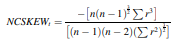

### The element n denotes the number of one-minute Bitcoin returns, whereas r denotes the intra-day one-minute Bitcoin return.

In [41]:
BTC_30m["Return"] = BTC_30m["Close"]/BTC_30m["Close"].shift(-1) - 1 
BTC_30m["Year"]  = BTC_30m["Date"].apply(lambda x: x.year)
BTC_30m["Month"] = BTC_30m["Date"].apply(lambda x: x.month)
BTC_30m["Day"]   = BTC_30m["Date"].apply(lambda x: x.day)
BTC_30m["crash_time"] = BTC_30m['Return'].apply(lambda x: 1 if x >= 0 else 0)

In [42]:
# Create 2 new columns containing Return**2 and Return**3
BTC_30m["Return^3"] = BTC_30m["Return"].apply(lambda x: math.pow(x,3))
BTC_30m["Return^2"] = BTC_30m["Return"].apply(lambda x: math.pow(x,2))

In [43]:
# Prepare the dataset to calculate the NCSKEW
BTC_NCSKEW = BTC_30m.groupby(by = ['Year',"Month","Day"],
                        axis = 0).agg({"Close":"count","Return^3":"sum", "Return^2":"sum"}).reset_index(level = [0,1,2])

# Calculate NCSKEW variable
BTC_NCSKEW["NCSKEW"] = -(BTC_NCSKEW["Close"]*(BTC_NCSKEW["Close"] - 1)**(3/2)*(BTC_NCSKEW["Return^3"]))/((
                          
                          BTC_NCSKEW["Close"]-1)*(
                          BTC_NCSKEW["Close"]-2)*(BTC_NCSKEW["Return^2"])**(3/2))
print("Calculate NCSKEW successfully")

Calculate NCSKEW successfully


In [44]:
BTC_NCSKEW.head()

,Year,Month,Day,Close,Return^3,Return^2,NCSKEW
0,2016,5,31,48,9.377811e-06,0.001308,-1.417956
1,2016,6,1,48,-1.711690e-06,0.000587,0.861590
2,2016,6,2,48,-5.174702e-07,0.000488,0.342914
3,2016,6,3,48,-2.112342e-05,0.001487,2.634216
4,2016,6,4,48,5.538948e-06,0.001252,-0.894405


### **DUVOLt, “down-to-up volatility”,** is less sensitive to extreme returns, as it does not consider the third moment, defined as:

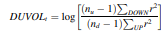



For in minute level, the mean and median return of bitcoin are very close to zero, ***nu and nd denote the number of positive and negative minute returns*** within a day respectively. Then we compute the standard deviation for each of these subsamples separately. 


In [45]:
# Calculate DUVOL variable

BTC_1d["DUVOL"] = (BTC_1d["N_minus"] -1)*BTC_1d["Return_N<0"]/((BTC_1d["N_plus"] -1)*BTC_1d["Return_N>0"])
BTC_1d["DUVOL"] = BTC_1d["DUVOL"].apply(lambda x: math.log(x))

### **CRASHt**

The 3rd measure **CRASHt** is **a dummy variable**. If **the return for dayt is less than mean return minus one standard deviation**, we define CRASHt **equals to 1,** otherwise CRASHt **equals to 0**. 

CRASH == 1 if rBTC-day < meanBTC30m/day - stdBTC-30m/day else == 0

In [46]:
# Dataframe includes the 30m each day from 2016-05-31 to 2022 - 05-21
BTC_30m_STD_mean = BTC_30m.groupby(["Year","Month","Day"]).agg({"Return":"std"}).reset_index(level = [0,1,2]).rename(columns = {"Return":"Std_30m_day"}).merge(
    BTC_30m.groupby(["Year","Month","Day"]).agg({"Return":"mean"}).reset_index(level = [0,1,2]).rename(columns = {"Return":"Mean_30m_std"}), 
    on = ["Year","Month","Day"], 
    how = "inner"
)

In [47]:
BTC_30m_STD_mean["Date"] = np.zeros(BTC_30m_STD_mean.shape[0]).reshape(-1,1)
for i in range(BTC_30m_STD_mean.shape[0]):
  BTC_30m_STD_mean["Date"][i] = str(BTC_30m_STD_mean["Year"][i]) + '-' + str(BTC_30m_STD_mean["Month"][i]) + '-' + str(BTC_30m_STD_mean["Day"][i]) 
BTC_30m_STD_mean["Date"] = pd.to_datetime(BTC_30m_STD_mean["Date"])

BTC_CRASH = BTC_1d[["Date","Return_x"]].merge(BTC_30m_STD_mean, on = "Date", how = "inner")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [48]:
BTC_CRASH["Crash"] = BTC_CRASH.apply(lambda x: 1 if x["Return_x"] < (x["Mean_30m_std"] - x["Std_30m_day"]) else 0, axis = 1)

In [81]:
BTC_CRASH

,Date,Return_x,Year,Month,Day,Std_30m_day,Mean_30m_std,Crash
0,2016-05-31,NaN,2016,5,31,0.005270,0.000250,0
1,2016-06-01,0.010414,2016,6,1,0.003524,-0.000247,0
2,2016-06-02,0.001959,2016,6,2,0.003222,-0.000119,0
3,2016-06-03,0.058036,2016,6,3,0.005511,-0.001119,0
4,2016-06-04,0.006207,2016,6,4,0.005160,-0.000131,0
...,...,...,...,...,...,...,...,...
2169,2022-05-16,-0.046069,2022,5,16,0.006862,0.000766,1
2170,2022-05-17,0.018851,2022,5,17,0.005481,-0.000408,0
2171,2022-05-18,-0.056057,2022,5,18,0.004537,0.001216,1
2172,2022-05-19,0.055503,2022,5,19,0.004506,-0.000872,0


# **Independent Variables**

### **The Bitcoin-Ethereum price synchronicity for day t** is calculated as the  ogarithm of the ratio of explained return variance to unexplained return variance, as below: 

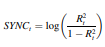

#### rEthereum t,m is Ethereum’s intraday return, t denotes trading day, m denotes intraday trading minute. rBitcoin t,m is Bitcoin’s intraday return for minute m . 
#### We correct for **nonsynchronous trading by including lead and lag terms of Bitcoin’s return**. The Bitcoin-Ethereum price synchronicity for **day t** is calculated as the **logarithm of the ratio** of explained return variance to unexplained return variance, as below:

image.png



In [49]:
# import library to predict R_ethereum and evaluate R2_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Create a function to calculate R2 for each day

def LinearRegression_ETH_BTC(data):
  # Return_y, Return_BTC_1, Return_BTC__1 respectively denote BTC's return including lag and lead term
  x = data[["Return_y","Return_BTC_1","Return_BTC__1"]]

  # Return_x denotes ETH's intraday return 
  y = data["Return_x"]
  model.fit(x,y)
  return model.predict(x)

# Function r2_rmse
def r2_rmse(data):
  r2 = r2_score(data["Return_x"],data["predict"])
  return pd.Series(r2)

In [50]:
# Dataset including ETH_BTC at 30 minute level/interval
ETH_BTC = ETH.merge(BTC, on = "Date", how = "inner")
ETH_BTC["Return_BTC"] = ETH_BTC["Close_y"]/ETH_BTC["Close_y"].shift(-1) - 1 

In [51]:
# Extract new table with 4 main columns: ETH, BTC+1, BTC-1 and BTC (lead and lag terms)
ETH_BTC = ETH_BTC[["Date","Return_x","Return_y"]]           
ETH_BTC["Return_BTC_1"] = ETH_BTC["Return_y"].shift(1)   # lead
ETH_BTC["Return_BTC__1"] = ETH_BTC["Return_y"].shift(-1) # lag


# Group by data by year, month, day to apply function -> estimate predict result with regression 
ETH_BTC["Year"]  = ETH_BTC["Date"].apply(lambda x: x.year)
ETH_BTC["Month"] = ETH_BTC["Date"].apply(lambda x: x.month)
ETH_BTC["Day"]   = ETH_BTC["Date"].apply(lambda x: x.day)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [52]:
# Create a column formating "%Y-%M-%D" (remove hour/minute) from column Date
ETH_BTC["Date_day"] = ETH_BTC.apply(lambda x: datetime.date( x["Year"],x["Month"],x["Day"]), axis = 1)

# Create a column containing predict value, firstly assigned with value: 0 in all index. 
ETH_BTC["predict"]  = np.zeros(ETH_BTC.shape[0]).reshape(-1,1)

In [53]:
ETH_BTC.dropna(axis = 0,inplace = True)
#Predict value for each day
for i in set(ETH_BTC["Date_day"]):
  ETH_BTC.loc[ETH_BTC["Date_day"] == i,"predict"] = LinearRegression_ETH_BTC(ETH_BTC.loc[ETH_BTC["Date_day"] == i])

In [57]:
SYNC = ETH_BTC.groupby(["Year","Month","Day"]).apply(r2_rmse).reset_index(level = [0,1,2]).rename(columns = {0:"R^2"})
SYNC["SYNC"] = SYNC["R^2"].apply(lambda x: math.log(x/(1-x)))

In [58]:
SYNC["Date"] = np.zeros(SYNC.shape[0]).reshape(-1,1)
for i in range(SYNC.shape[0]):
  SYNC["Date"][i] = str(SYNC["Year"][i]) + '-' + str(SYNC["Month"][i]) + '-' + str(SYNC["Day"][i]) 
SYNC["Date"] = pd.to_datetime(SYNC["Date"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [59]:
SYNC.head()

,Year,Month,Day,R^2,SYNC,Date
0,2016,6,1,0.024972,-3.664720,2016-06-01
1,2016,6,2,0.078628,-2.461129,2016-06-02
2,2016,6,3,0.060460,-2.743416,2016-06-03
3,2016,6,4,0.040973,-3.153012,2016-06-04
4,2016,6,5,0.018764,-3.956892,2016-06-05


###**UPSDt is upside volatility of Bitcoin**, defined as semi-standard deviation of positive returns in one trading day. 

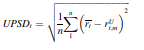

rUt,m denotes positive return sequence for day t and rt denotes mean of positive returns for day t. UPSDt is the opposite of downside
risk measure. When UPSDt is high, Bitcoin price is skyrocketing. All other control variables are in percentage change calculated with Python statistical software (sklearn library)

In [60]:
BTC_STD = BTC_30m.groupby(by = ['Year',"Month","Day","crash_time"],
                        axis = 0).agg({"Return":"std"}).reset_index(level = [0,1,2,3])
UPSD = BTC_STD.loc[BTC_STD["crash_time"] == 1].set_index("Year").reset_index()
UPSD.rename(columns = {"Return":"UPSD"}, inplace = True)

In [61]:
UPSD["Date"] = np.zeros(UPSD.shape[0]).reshape(-1,1)
for i in range(UPSD.shape[0]):
  UPSD["Date"][i] = str(UPSD["Year"][i]) + '-' + str(UPSD["Month"][i]) + '-' + str(UPSD["Day"][i]) 
UPSD["Date"] = pd.to_datetime(UPSD["Date"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [62]:
UPSD.head()

,Year,Month,Day,crash_time,UPSD,Date
0,2016,5,31,1,0.004869,2016-05-31
1,2016,6,1,1,0.001869,2016-06-01
2,2016,6,2,1,0.002030,2016-06-02
3,2016,6,3,1,0.001608,2016-06-03
4,2016,6,4,1,0.004619,2016-06-04


# **Emperial Testing**

## **Table 1:** gives the descriptive statistics of research variables, all of which are winsorized at 99% to rule out the effect of extreme values.

In [63]:
# Preprocessing dataset
ETH_30m["Year"]  = ETH_30m["Date"].apply(lambda x: x.year)
ETH_30m["Month"] = ETH_30m["Date"].apply(lambda x: x.month)
ETH_30m["Day"]   = ETH_30m["Date"].apply(lambda x: x.day)
ETH_30m["Date_day"] = ETH_30m.apply(lambda x: datetime.date(x["Year"],x["Month"],x["Day"]), axis = 1)
ETH_1d = ETH_30m.drop_duplicates("Date_day")
#
BTC_1d.drop(index = 0, inplace = True)
#

In [64]:
# BTC_NCSKEW columns for merging
BTC_NCSKEW["Date"] = np.zeros(BTC_NCSKEW.shape[0]).reshape(-1,1)
for i in range(BTC_NCSKEW.shape[0]):
  BTC_NCSKEW["Date"][i] = str(BTC_NCSKEW["Year"][i]) + '-' + str(BTC_NCSKEW["Month"][i]) + '-' + str(BTC_NCSKEW["Day"][i]) 
BTC_NCSKEW["Date"] = pd.to_datetime(BTC_NCSKEW["Date"])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [65]:
gold.reset_index(inplace = True)
SP_500_index.reset_index(inplace = True) 
SP_500_index.rename(columns = {"DATE":"Date"}, inplace = True)

In [66]:
# Merge dataset including control variables, dependent variables and independent variables
df = BTC_NCSKEW[["Date","NCSKEW"]].merge(BTC_1d[["Date","DUVOL"]],
                      on = "Date").merge(BTC_CRASH[["Crash","Date"]],
                      on = "Date").merge(SYNC[["SYNC","Date"]], 
                      on = "Date").merge(UPSD[["UPSD","Date"]],
                      on = "Date").merge(SP_500_index, 
                      on = "Date").merge(sentiment[["Date","Sentiment"]], 
                      on = "Date").merge(gold[["Date","Return_gold"]], 
                      on = "Date").merge(B_T,
                      on = "Date").merge(D_index,
                      on = "Date").merge(vix,
                      on = "Date").merge(wti, 
                      on = "Date")
df.drop("Date", axis = 1,inplace = True)
df["SYNC_UPSD"] = df.apply(lambda x: x["SYNC"]*x["UPSD"], axis = 1)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1498 entries, 0 to 1497
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NCSKEW         1498 non-null   float64
 1   DUVOL          1498 non-null   float64
 2   Crash          1498 non-null   int64  
 3   SYNC           1498 non-null   float64
 4   UPSD           1498 non-null   float64
 5   index          1498 non-null   int64  
 6   sp500          1498 non-null   float64
 7   Sentiment      1497 non-null   float64
 8   Return_gold    1498 non-null   float64
 9   T_Bill         1498 non-null   float64
 10  Dollar_Index   1498 non-null   float64
 11  VIX            1498 non-null   float64
 12  WTI_Oil_price  1498 non-null   float64
 13  SYNC_UPSD      1498 non-null   float64
dtypes: float64(12), int64(2)
memory usage: 175.5 KB


In [68]:
# Winsorize dataset from 1 - 99% to remove outlier
from scipy.stats.mstats import winsorize
for col in df.columns:
    df[col] = winsorize(df[col], limits=[0.01, 0.01])

## **Table 1:**Descriptive statistics of research variables

In [69]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
NCSKEW,1498.0,-0.048811,1.499316,-4.396332,-0.926085,-0.054534,0.776588,4.398178
DUVOL,1498.0,0.034539,1.015347,-2.394773,-0.633697,0.041474,0.702390,2.682281
Crash,1498.0,0.406542,0.491352,0.000000,0.000000,0.000000,1.000000,1.000000
SYNC,1498.0,-1.885254,1.274029,-5.377803,-2.677518,-1.832892,-1.039656,1.164573
UPSD,1498.0,0.003717,0.002855,0.000639,0.001845,0.002924,0.004624,0.017053
index,1498.0,782.047397,448.610935,14.000000,393.250000,783.500000,1168.750000,1543.000000
sp500,1498.0,3111.261222,749.763224,2088.900000,2566.017500,2878.430000,3625.590000,4701.460000
Sentiment,1498.0,-0.002071,0.353312,-1.572843,-0.074632,-0.006053,0.058520,1.801284
Return_gold,1498.0,0.000345,0.007908,-0.022642,-0.004166,0.000628,0.004885,0.021694
T_Bill,1498.0,2.451871,0.579376,1.220000,2.030500,2.496000,2.982750,3.370000


##**Table 2:** Pearson correlation matrix of variables.

In [70]:
corr = df.corr()
corr

,NCSKEW,DUVOL,Crash,SYNC,UPSD,index,sp500,Sentiment,Return_gold,T_Bill,Dollar_Index,VIX,WTI_Oil_price,SYNC_UPSD
NCSKEW,1.000000,0.894673,-0.576465,-0.146311,-0.405276,-0.010090,-0.000488,-0.003265,0.085908,-0.005914,-0.023303,-0.013236,-0.019147,0.042701
DUVOL,0.894673,1.000000,-0.717332,-0.136263,-0.358212,-0.026922,-0.023616,0.018051,0.114813,-0.013614,-0.000864,-0.019785,-0.057958,0.031358
Crash,-0.576465,-0.717332,1.000000,0.170800,0.248483,0.066711,0.068461,0.002481,-0.087845,-0.011021,-0.026067,0.010136,0.090824,0.020003
SYNC,-0.146311,-0.136263,0.170800,1.000000,0.198793,0.160265,0.109500,-0.031577,0.003073,0.003355,-0.019551,0.105849,0.201271,0.590823
UPSD,-0.405276,-0.358212,0.248483,0.198793,1.000000,-0.036567,-0.017633,0.000046,-0.047246,0.086830,-0.187153,0.027962,-0.047429,-0.494921
index,-0.010090,-0.026922,0.066711,0.160265,-0.036567,1.000000,0.931005,-0.015103,0.007976,-0.580315,-0.166584,0.527289,0.135104,0.089521
sp500,-0.000488,-0.023616,0.068461,0.109500,-0.017633,0.931005,1.000000,-0.036748,-0.002864,-0.459959,-0.277635,0.294710,0.123784,0.037659
Sentiment,-0.003265,0.018051,0.002481,-0.031577,0.000046,-0.015103,-0.036748,1.000000,0.017397,0.019070,0.033070,0.040250,-0.019414,-0.030045
Return_gold,0.085908,0.114813,-0.087845,0.003073,-0.047246,0.007976,-0.002864,0.017397,1.000000,-0.049919,-0.006345,0.011536,-0.012758,0.012911
T_Bill,-0.005914,-0.013614,-0.011021,0.003355,0.086830,-0.580315,-0.459959,0.019070,-0.049919,1.000000,0.126876,-0.587810,0.487446,-0.051215


##**Table 3:** 
Regression results of model (6).
To test the hypothesis that when Bitcoin price is skyrocketing, synchronized Ethereum rise is positively correlated to Bitcoin crash risk, we use following model to conduct empirical tests:

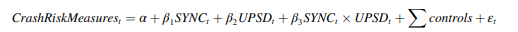 (6)

**The dependent variable** CrashRiskMeasurest here stands for 3 kinds of crash risk measures:NCSKEWt,DUVOLt,CRASHt. 

**∑controls** stands for control variables including daily return of gold price (gold), Stand & Poor Index (spx), dollar index (usdx), volatility index (vix), wti crude oil (wti), 30-year treasury bond (T − bond), and investor sentiment index data issued by Federal Reserve Bank of San
Francisco (sentiment). 

### **Model testing**

In [76]:
# Model 1: Dependent variable of Model [1] is NCSKEW (negative coefficient of skewness, 
# defined in formula (1)) and the regression type is Newey West
new_west_NCSKEW = smf.ols( formula = 'NCSKEW ~ SYNC + UPSD + SYNC_UPSD + sp500 + Sentiment + Return_gold + T_Bill + Dollar_Index + VIX+ WTI_Oil_price',
                         data = df).fit(cov_type='HAC',cov_kwds={'maxlags':1})
print(new_west_NCSKEW.summary())

                            OLS Regression Results                            
Dep. Variable:                 NCSKEW   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     25.89
Date:                Thu, 26 May 2022   Prob (F-statistic):           9.72e-46
Time:                        13:59:50   Log-Likelihood:                -2534.4
No. Observations:                1498   AIC:                             5091.
Df Residuals:                    1487   BIC:                             5149.
Df Model:                          10                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.6867      1.058      4.431

In [77]:
# Model 2: Dependent variable of Model [1] is DUVOL (negative coefficient of skewness, 
# defined in formula (1)) and the regression type is Newey West
new_west_DUVOL= smf.ols( formula = 'DUVOL ~ SYNC + UPSD + SYNC_UPSD + sp500 + Sentiment + Return_gold + T_Bill + Dollar_Index + VIX+ WTI_Oil_price',
                         data = df).fit(cov_type='HAC',cov_kwds={'maxlags':1})
print(new_west_DUVOL.summary())


                            OLS Regression Results                            
Dep. Variable:                  DUVOL   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     22.33
Date:                Thu, 26 May 2022   Prob (F-statistic):           2.62e-39
Time:                        13:59:55   Log-Likelihood:                -1988.9
No. Observations:                1498   AIC:                             4000.
Df Residuals:                    1487   BIC:                             4058.
Df Model:                          10                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.5010      0.768      3.258

In [78]:
# Model 3: A quantile regression (τ = 0.9) is included as of model [3]. F-value of model [3]
# is the Wald test result between median and 90% quantile.

NCSKEW_quantile = smf.quantreg( formula = 'NCSKEW ~ SYNC + UPSD + SYNC_UPSD + sp500 + Sentiment + Return_gold + T_Bill + Dollar_Index + VIX+ WTI_Oil_price', data = df).fit(q = 0.9)
print(NCSKEW_quantile.summary())

                         QuantReg Regression Results                          
Dep. Variable:                 NCSKEW   Pseudo R-squared:               0.1090
Model:                       QuantReg   Bandwidth:                      0.5227
Method:                 Least Squares   Sparsity:                        6.151
Date:                Thu, 26 May 2022   No. Observations:                 1498
Time:                        14:00:00   Df Residuals:                     1487
                                        Df Model:                           10
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.2788      1.685      3.727      0.000       2.975       9.583
SYNC              0.3380      0.093      3.620      0.000       0.155       0.521
UPSD           -133.9580     28.259     -4.740      0.000    -189.390     -78.526
SYNC_UPSD        42.8610     23.327  

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


In [79]:
# Dependent variable of Model [4] is CRASH (dummy variable to indicate whether Bitcoin is
# Crashed during that day), so the regression type is changed to logit. 
# F-Value of Newey West regression is reported while Log-Likelihood is reported for
# logit regression.

CRASH_logit = smf.logit('Crash ~ SYNC + UPSD + SYNC_UPSD + sp500 + Sentiment + Return_gold + T_Bill + Dollar_Index + VIX+ WTI_Oil_price', data = df).fit()
print(CRASH_logit.summary())

Optimization terminated successfully.
         Current function value: 0.612712
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Crash   No. Observations:                 1498
Model:                          Logit   Df Residuals:                     1487
Method:                           MLE   Df Model:                           10
Date:                Thu, 26 May 2022   Pseudo R-squ.:                 0.09305
Time:                        14:00:02   Log-Likelihood:                -917.84
converged:                       True   LL-Null:                       -1012.0
Covariance Type:            nonrobust   LLR p-value:                 4.334e-35
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.6213      1.939     -1.867      0.062      -7.422       0.180
SYNC             -0.

### **Summary**

In [80]:
# Well, there is summary_col in statsmodels; it doesn't have all the bells and whistles of estout, 
# but it does have the basic functionality you are looking for (including export to LaTeX):
from statsmodels.iolib.summary2 import summary_col
print(summary_col([new_west_NCSKEW,new_west_DUVOL,NCSKEW_quantile,CRASH_logit],stars=True,float_format='%0.2f'))


               NCSKEW I   DUVOL I   NCSKEW II   Crash I 
--------------------------------------------------------
Intercept     4.69***    2.50***    6.28***    -3.62*   
              (1.06)     (0.77)     (1.68)     (1.94)   
SYNC          0.27***    0.18***    0.34***    -0.22**  
              (0.06)     (0.04)     (0.09)     (0.09)   
UPSD          -355.78*** -215.07*** -133.96*** 405.65***
              (27.77)    (18.55)    (28.26)    (48.48)  
SYNC_UPSD     -93.74***  -58.52***  42.86*     117.57***
              (12.35)    (8.51)     (23.33)    (23.14)  
sp500         0.00       -0.00      -0.00***   0.00     
              (0.00)     (0.00)     (0.00)     (0.00)   
Sentiment     -0.05      0.03       -0.04      0.10     
              (0.10)     (0.07)     (0.13)     (0.16)   
Return_gold   11.79***   11.92***   2.42       -21.58***
              (4.26)     (3.04)     (7.34)     (7.19)   
T_Bill        0.31***    0.17**     -0.00      -0.58*** 
              (0.10)     (0.07

# **Appendix: Graphic exploration**


In [82]:
# Data manipulation
# ==============================================================================
import pandas as pd
import numpy as np
import datetime
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')

# Bitcoin colors
# ==============================================================================
palette_btc = {'orange': '#f7931a',
               'white' : '#ffffff',
               'gray'  : '#4d4d4d',
               'blue'  : '#0d579b',
               'green' : '#329239'
              }

# **Appendix 2: BITCOIN/USD Chart 2016 - 2022**

In [83]:
data = BTC_1d.copy()
candlestick = go.Candlestick(
                    x     = data.index,
                    open  = data.Open,
                    close = data.Close_x,
                    low   = data.Low,
                    high  = data.High,
                    )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='<b>Bitcoin/USD Chart</b>', font=dict(size=30)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20)
)

fig.show()

## **Appendix 3: Data distribution**

The distribution of the Bitcoin closing price, variable close, is shown:

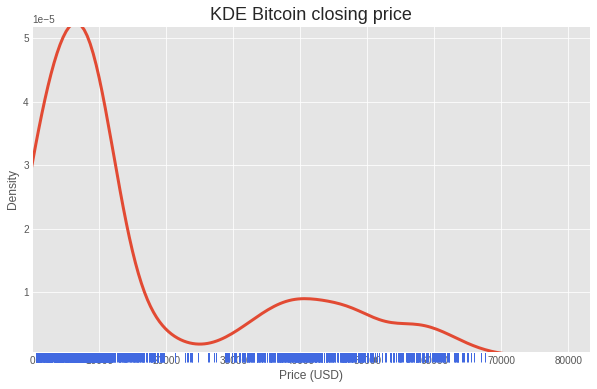

In [84]:
# KDE distribution of Bitcoin closing price
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
p = sns.kdeplot(data=data, x='Close_x', linewidth=3, ax=ax)
r = sns.rugplot(data=data, x='Close_x', ax=ax, c='royalblue',
                height=-.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title('KDE Bitcoin closing price', fontsize=18)
p.set_xlabel('Price (USD)');

## **Append 4: Price per year from 2016 - 2022**


In [85]:
# Locate corresponding data for each year
# ==============================================================================
years = list(data.Year.unique())
df_plot = pd.DataFrame()

for year in years:
    
    year_open  = data.loc[data.Year == year, 'Open'].iloc[0]
    year_close = data.loc[data.Year == year, 'Close_x'].iloc[-1]
    year_low   = data.loc[data.Year == year, 'Low'].min()
    year_high  = data.loc[data.Year == year, 'High'].max()
    
    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high]) 
    
df_plot = df_plot.T
df_plot = df_plot.set_axis(['Open', 'Close', 'Low', 'High'], axis=1)

# Calculate % change between the open and close price of the year
# ==============================================================================
df_plot['year_change'] = 100*(df_plot['Close'] - df_plot['Open']) / df_plot['Open']
df_plot.head(3)

,Open,Close,Low,High,year_change
2016,531.106995,963.742981,525.635986,979.396973,81.459290
2017,963.658020,14156.400391,755.755981,20089.000000,1369.027404
2018,14112.200195,3742.700439,3191.303467,17712.400391,-73.478973


In [86]:
# Create a list of dicts with the % change annotations for the plot
# ==============================================================================
annotations_list = []
max_high = df_plot['High'].max()

for year in years:
    
    df_aux = df_plot.loc[df_plot.index == year,]
    loc_x = pd.to_datetime(df_aux.index[0], format='%Y')
    loc_y = df_aux['High'].values[0]/max_high + 0.05
    text = '{:.1f}%'.format(df_aux['year_change'].values[0])
    
    annotation = dict(x=loc_x, y=loc_y, 
                      xref='x', yref='paper',
                      showarrow=False, xanchor='center', 
                      text=text)

    annotations_list.append(annotation)

# Interactive candlestick chart with Plotly
# ==============================================================================
candlestick = go.Candlestick(
                    x     = pd.to_datetime(df_plot.index, format='%Y'),
                    open  = df_plot.Open,
                    close = df_plot.Close,
                    low   = df_plot.Low,
                    high  = df_plot.High
                    )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 800,
    height      = 350,
    title       = dict(text='<b>Bitcoin/USD yearly chart</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20),
    xaxis_rangeslider_visible = False,
    annotations = annotations_list
    )

fig.show()

##**Appendix 5: Annual, monthly and weekly seasonality**

In [87]:
# Locate corresponding data for each month
# ==============================================================================
years = list(data.Year.unique())
df_plot = pd.DataFrame()

for year in years:
    for month in range(12):
        start_date = pd.to_datetime(f'{year}-{month+1}-01', format='%Y-%m-%d')
        end_date = (start_date + pd.offsets.MonthBegin())
        mask = (data["Date"] >= start_date) & (data["Date"] < end_date)
        
        if not data.loc[mask, :].empty:
                        
            month_open  = data.loc[mask, 'Open'].iloc[0]
            month_close = data.loc[mask, 'Close_x'].iloc[-1]
            month_low   = data.loc[mask, 'Low'].min()
            month_high  = data.loc[mask, 'High'].max()
            
            serie  = pd.Series([month_open, month_close, month_low, month_high])
            df_aux = pd.DataFrame(serie, columns=[f'{str(month+1).zfill(2)}-{year}'])
            
            if df_plot.empty:
                df_plot = df_aux.copy()
            else:
                df_plot = pd.concat([df_plot, df_aux], axis=1)

df_plot = df_plot.T
df_plot = df_plot.set_axis(['Open', 'Close', 'Low', 'High'], axis=1)

In [88]:
# Boxplot chart for annual seasonality
# ==============================================================================
# df_plot['month'] = pd.to_datetime(df_plot.index, format='%m-%Y').month
# fig, ax = plt.subplots(figsize=(7, 3.5))
# df_plot.boxplot(column='close', by='month', ax=ax)
# df_plot.groupby('month')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Price (USD)')
# ax.set_title('BTC Price per month')
# fig.suptitle('');

df_plot['month'] = pd.to_datetime(df_plot.index, format='%m-%Y').month
# fig 1 monthly boxplot
fig1 = px.box(df_plot.sort_values('month'), x='month', y='Close',
              color_discrete_sequence=[palette_btc['green']])

# fig 2 line with median data for each month
df_median = pd.DataFrame(df_plot.groupby('month')['Close'].median()).reset_index()
fig2 = px.line(df_median, x='month', y='Close', markers=True,
               color_discrete_sequence=[palette_btc['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Price per month</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='month', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
    )

fig.show()

In [89]:
# Boxplot chart for monthly seasonality
# ==============================================================================
# fig, ax = plt.subplots(figsize=(9, 3.5))
# data['day'] = pd.Series(data.index).dt.day.values
# data.boxplot(column='close', by='day', ax=ax)
# data.groupby('day')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Price (USD)')
# ax.set_title('BTC Price per day of the month')
# fig.suptitle('');


# fig 1 dayly boxplot
fig1 = px.box(data.sort_values('Day'), x='Day', y='Close_x',
              color_discrete_sequence=[palette_btc['green']])

# fig 2 line with median data for each day
df_median = pd.DataFrame(data.groupby('Day')['Close_x'].median()).reset_index()
fig2 = px.line(df_median, x='Day', y='Close_x', markers=True,
               color_discrete_sequence=[palette_btc['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 750,
    height      = 350,
    title       = dict(text='<b>BTC Price per day of the month</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear', tickangle=0, range=[0.5, 31.5]),
    xaxis_title = dict(text='Day', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
    )

fig.show()

In [90]:
# Boxplot chart for weekly seasonality
# ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3.5))
# data['weekday'] = data.index.day_of_week + 1
# data.boxplot(column='close', by='weekday', ax=ax)
# data.groupby('weekday')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Price (USD)')
# ax.set_title('BTC Price per day of the week');
data.set_index("Date",inplace = True)
data['weekday'] = data.index.day_of_week + 1

# fig 1 weekly boxplot
fig1 = px.box(data.sort_values('weekday'), x='weekday', y='Close_x',
              color_discrete_sequence=[palette_btc['green']])

# fig 2 line with median data for each weekday
df_median = pd.DataFrame(data.groupby('weekday')['Close_x'].median()).reset_index()
fig2 = px.line(df_median, x='weekday', y='Close_x', markers=True,
               color_discrete_sequence=[palette_btc['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Price per day of the week</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='weekday', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
    )

fig.show()

## **Appendix 6: Data visualization of Control Variables**

Text(0.5, 1.0, 'W&T Offshore, Inc. (WTI) NYSE - Nasdaq Real Time Price. Currency in USD')

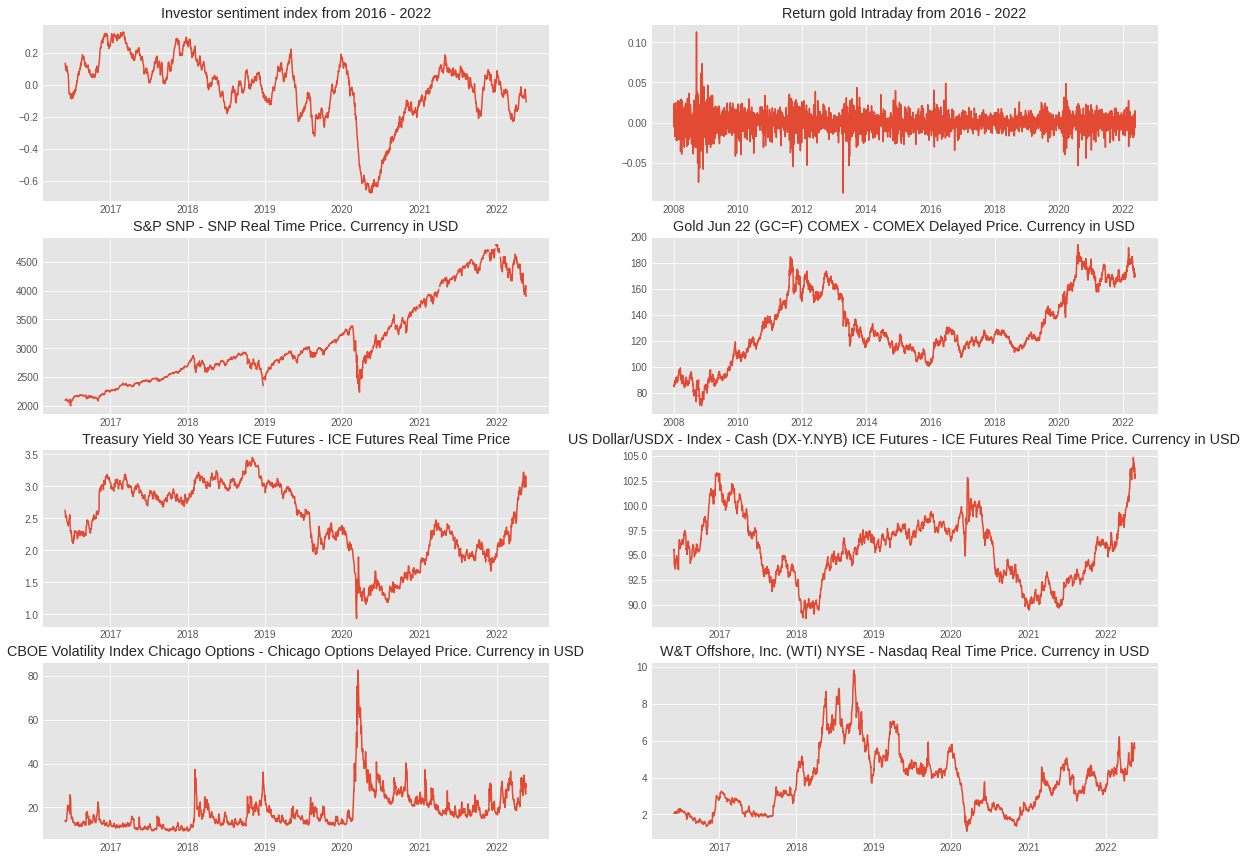

In [91]:
fig, ax = plt.subplots( nrows = 4, ncols = 2, figsize = (20,15))
ax[0][0].plot(sentiment["Date"],sentiment["News_Sentiment"])
ax[0][0].set_title("Investor sentiment index from 2016 - 2022")
ax[0][1].plot(gold["Date"],gold["Return_gold"])
ax[0][1].set_title("Return gold Intraday from 2016 - 2022")
ax[1][0].plot(SP_500_index["Date"], SP_500_index["sp500"])
ax[1][0].set_title("S&P SNP - SNP Real Time Price. Currency in USD")
ax[1][1].plot(gold["Date"],gold["Gold"])
ax[1][1].set_title("Gold Jun 22 (GC=F) COMEX - COMEX Delayed Price. Currency in USD")
ax[2][0].plot(B_T["Date"],B_T["T_Bill"])
ax[2][0].set_title("Treasury Yield 30 Years ICE Futures - ICE Futures Real Time Price")
ax[2][1].plot(D_index["Date"],D_index["Dollar_Index"])
ax[2][1].set_title("US Dollar/USDX - Index - Cash (DX-Y.NYB) ICE Futures - ICE Futures Real Time Price. Currency in USD")
ax[3][0].plot(vix["Date"],vix["VIX"])
ax[3][0].set_title("CBOE Volatility Index Chicago Options - Chicago Options Delayed Price. Currency in USD")
ax[3][1].plot(wti["Date"],wti["WTI_Oil_price"])
ax[3][1].set_title("W&T Offshore, Inc. (WTI) NYSE - Nasdaq Real Time Price. Currency in USD")

## **Appendix 7: Data visualization Crash risk - SYNC and UPSD betwenn Bitcoin & Ethereum from 2016 - 2022**.

Text(0.5, 1.0, 'Crash risk: CRASH between Bitcoin & Ethereum')

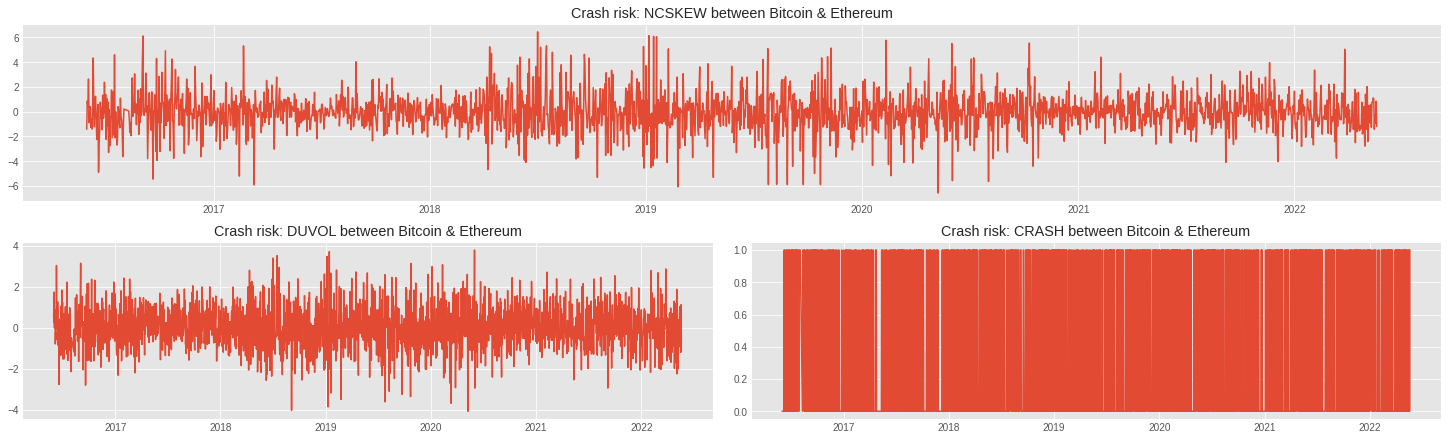

In [92]:
fig = plt.figure(figsize=(20,6), constrained_layout=True)
spec = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(spec[0, :])
ax1 = fig.add_subplot(spec[1, 0])
ax2 = fig.add_subplot(spec[1, 1])

ax0.plot(BTC_NCSKEW["Date"], BTC_NCSKEW["NCSKEW"])
ax0.set_title("Crash risk: NCSKEW between Bitcoin & Ethereum")
ax1.plot(BTC_1d["Date"],BTC_1d["DUVOL"])
ax1.set_title("Crash risk: DUVOL between Bitcoin & Ethereum")
ax2.plot(BTC_CRASH["Date"], BTC_CRASH["Crash"])
ax2.set_title("Crash risk: CRASH between Bitcoin & Ethereum")


In [93]:
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Box(
    y = BTC_1d["DUVOL"],
    name = "DUVOL",
    marker_color = 'darkblue',
    boxmean = True,
    jitter=0.5,
    whiskerwidth=0.2,
    marker_size=2,
    line_width=1
))
fig.add_trace(go.Box(
    y = BTC_NCSKEW["NCSKEW"],
    name = "NCSKEW",
    marker_color = "royalblue",
    boxmean = True,
    jitter=0.5,
    whiskerwidth=0.2,
    marker_size=2,
    line_width=1
)
)

fig.add_trace(go.Box(
    y = BTC_CRASH["Crash"],
    name = "CRASH",
    marker_color = 'rgb(9,56,125)',
    boxmean = True,
    jitter=0.5,
    whiskerwidth=0.2,
    marker_size=2,
    line_width=1
)
)

fig.add_trace(go.Box(
    y = SYNC["SYNC"],
    name = "SYNC",
    marker_color = 'rgb(9,56,125)',
    boxmean = True,
    jitter=0.5,
    whiskerwidth=0.2,
    marker_size=2,
    line_width=1
)
)

fig.add_trace(go.Box(
    y = UPSD["UPSD"],
    name = "UPSD",
    marker_color = 'rgb(9,56,125)',
    boxmean = True,
    jitter=0.5,
    whiskerwidth=0.2,
    marker_size=2,
    line_width=1
)
)


fig.update_layout(
    title=' <b> Crash risk betwenn Bitcoin & Ethereum - SYNC and UPSD from 2016 - 2022.</b>',
    title_x=0.5,
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    titlefont=dict(size =30, color='rgb(9,56,125)'),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False
)
